In [152]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
plt.style.use('seaborn')

In [153]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
y_train = train_data['actual_productivity'].to_numpy()
train_data = train_data.drop(['actual_productivity'], axis = 1)
data = pd.concat([train_data, test_data])

In [154]:
indexs = []
date = data.iat[0,0]
index = 0
for i in range(len(data)):
    if data.iat[i,0]==date:
        index+=1
        indexs.append(index)
    else:
        date = data.iat[i,0]
        index = 1
        indexs.append(index)

data.insert(0,'Index',indexs)
data

,Index,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
0,1,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0
1,2,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0
2,3,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5
3,4,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5
4,5,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,20,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0
236,21,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0
237,22,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0
238,23,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0


In [155]:
data = data.drop(['date', 'wip', 'quarter', 'department' ,'team','day'],axis = 1)
data = pd.get_dummies(data)


In [156]:
def normalization(data):
    mean = np.mean(data,axis=0)
    std = np.std(data,axis=0)
    return (data-mean)/std

In [157]:
data = normalization(data)
train_data = data[:len(y_train)].to_numpy()
test_data = data[len(y_train):].to_numpy()

indices = np.arange(len(y_train))
np.random.shuffle(indices)
train_data = train_data[indices]
y_train = y_train[indices]

print(train_data.shape, test_data.shape)

(957, 9) (240, 9)


In [158]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16,input_shape=(train_data.shape[1],),kernel_initializer='random_normal',bias_initializer='zeros',kernel_regularizer = regularizers.l1(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('gelu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(16,kernel_initializer='random_normal',bias_initializer='zeros',kernel_regularizer = regularizers.l1(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('gelu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(1,activation='sigmoid'))

    model.compile(loss=keras.losses.MeanAbsoluteError(),
                  optimizer=optimizers.Adam(learning_rate=1e-3),
                  metrics=keras.metrics.MeanAbsoluteError())
    return model

In [159]:
model = build_model()
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 16)                160       
_________________________________________________________________
batch_normalization_56 (Batc (None, 16)                64        
_________________________________________________________________
activation_56 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 16)                272       
_________________________________________________________________
batch_normalization_57 (Batc (None, 16)                64        
_________________________________________________________________
activation_57 (Activation)   (None, 16)              

In [160]:
history = model.fit(train_data,
                    y_train,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.3)

Epoch 1/100
42/42 [==============================] - 1s 10ms/step - loss: 0.3655 - mean_absolute_error: 0.3630 - val_loss: 0.2329 - val_mean_absolute_error: 0.2304
Epoch 2/100
42/42 [==============================] - 0s 8ms/step - loss: 0.2335 - mean_absolute_error: 0.2309 - val_loss: 0.1986 - val_mean_absolute_error: 0.1961
Epoch 3/100
42/42 [==============================] - 0s 8ms/step - loss: 0.1880 - mean_absolute_error: 0.1854 - val_loss: 0.1690 - val_mean_absolute_error: 0.1664
Epoch 4/100
42/42 [==============================] - 0s 8ms/step - loss: 0.1689 - mean_absolute_error: 0.1664 - val_loss: 0.1509 - val_mean_absolute_error: 0.1483
Epoch 5/100
42/42 [==============================] - 0s 8ms/step - loss: 0.1598 - mean_absolute_error: 0.1572 - val_loss: 0.1364 - val_mean_absolute_error: 0.1338
Epoch 6/100
42/42 [==============================] - 0s 8ms/step - loss: 0.1557 - mean_absolute_error: 0.1532 - val_loss: 0.1253 - val_mean_absolute_error: 0.1227
Epoch 7/100
42/42 [==

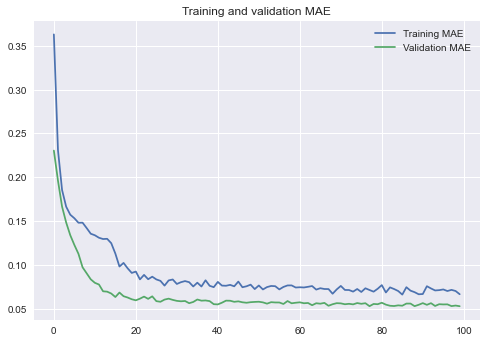

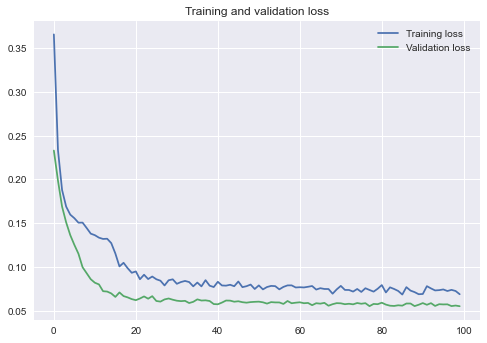

In [161]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

def plot_training(train_loss,val_loss,title,metrix):
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, '-', label='Training '+metrix)
    plt.plot(epochs, val_loss, '-', label='Validation '+metrix)
    plt.title(title)
    plt.legend()
    plt.show()

plot_training(mae,val_mae,'Training and validation MAE', 'MAE')
plot_training(loss,val_loss,'Training and validation loss', 'loss')

In [162]:
model = build_model()
model.fit(train_data,
          y_train,
          epochs=100,
          batch_size=16)

Epoch 1/100
60/60 [==============================] - 1s 7ms/step - loss: 0.2873 - mean_absolute_error: 0.2846
Epoch 2/100
60/60 [==============================] - 0s 7ms/step - loss: 0.1866 - mean_absolute_error: 0.1840
Epoch 3/100
60/60 [==============================] - 0s 7ms/step - loss: 0.1621 - mean_absolute_error: 0.1595
Epoch 4/100
60/60 [==============================] - 0s 7ms/step - loss: 0.1439 - mean_absolute_error: 0.1412
Epoch 5/100
60/60 [==============================] - 0s 7ms/step - loss: 0.1280 - mean_absolute_error: 0.1253
Epoch 6/100
60/60 [==============================] - 0s 7ms/step - loss: 0.1133 - mean_absolute_error: 0.1106
Epoch 7/100
60/60 [==============================] - 0s 7ms/step - loss: 0.1029 - mean_absolute_error: 0.1002
Epoch 8/100
60/60 [==============================] - 0s 7ms/step - loss: 0.1020 - mean_absolute_error: 0.0993
Epoch 9/100
60/60 [==============================] - 0s 7ms/step - loss: 0.0946 - mean_absolute_error: 0.0919
Epoch 10/1

In [163]:
result = model.predict(test_data)
result = list(result[:,0])
index = list(range(240))
dict = {'Id': index, 'actual_productivity': result} 
df = pd.DataFrame(dict) 
df.to_csv('110034529.csv', index = False)